In [1]:
import tensorflow as tf
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#np.set_printoptions(threshold=np.inf)
import time
import csv

In [2]:
##tr 0 to 3 is location value
ecg_filename = ["time_ecg_rpeak_yeop_sleep", "time_ecg_rpeak_yeopdata", "time_ecg_rpeak_yeop_friend_sleep"]

In [3]:
ecg_header = []
ecg_time = []
ecg_code = []
rpeak_time = []
rpeak_code = []
peak_index = []

In [4]:
def read_ecg_from_csv(ecg_filename):
    filename = "data/"+ecg_filename+".CSV"
    with open (filename,newline='',encoding = 'utf-8') as csvfile:
        reader = csv.reader(csvfile, delimiter = ',')
        ecg_header.append(reader.__next__())
        for row in reader:
            ecg_time.append(row[0])
            ecg_code.append(float(row[1]))
            rpeak_time.append(row[2])
            rpeak_code.append(row[3])
            if row[3] != "0":
                peak_index.append(row)

In [5]:
read_ecg_from_csv(ecg_filename[1])

In [6]:
print("peak_point_number : " + str(len(peak_index))+
      "\necg_data_number : "+str(len(ecg_time)))

peak_point_number : 2865
ecg_data_number : 587648


In [7]:
x_ = ecg_code[:287000]

x_temp = np.linspace(-10, 10, 500)
x_x_temp = list(map(lambda x: x*x + 2400, x_temp))
x_x_temp = (287*2)*x_x_temp
x_[287000:]=x_x_temp
print (len(x_))

tr_x =  np.reshape(x_,[-1,500])

574000


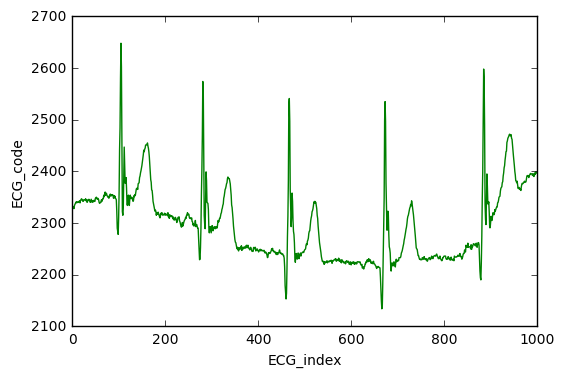

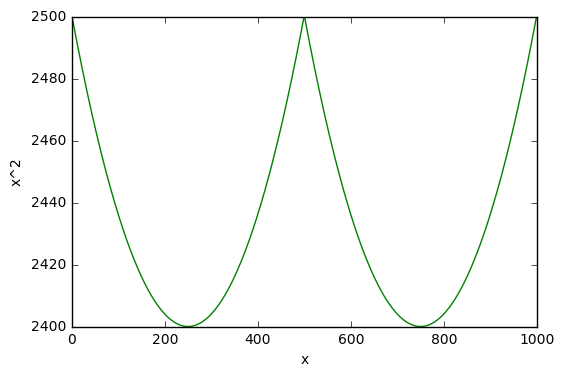

In [8]:
plt.plot(ecg_code[:1000],'g-')
plt.xlabel('ECG_index')
plt.ylabel('ECG_code')
plt.show()
plt.plot(x_x_temp[:1000],'g-')
plt.xlabel('x')
plt.ylabel('x^2')
plt.show()

In [9]:
y_= np.zeros((574*2,2), dtype = "float32")
for i in range(0,574*2):
    if i < 574:
        y_[i][0] = 1.0
    else:
        y_[i][1] = 1.0
print (y_)

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


In [10]:
ecg_header = []
ecg_time = []
ecg_code = []
rpeak_time = []
rpeak_code = []
peak_index = []

In [11]:
read_ecg_from_csv(ecg_filename[2])
print("peak_point_number : " + str(len(peak_index))+
      "\necg_data_number : "+str(len(ecg_time)))

peak_point_number : 5025
ecg_data_number : 1048575


In [12]:
x_t = ecg_code[:87000*2]
x_temp = np.linspace(-0.8, 0.8, 500)
x_x_temp = list(map(lambda x: x*x+2000, x_temp))
x_x_temp = (87*2)*x_x_temp

x_t[:87000] =x_x_temp

te_x =  np.reshape(x_t,[-1,500])

te_y= np.zeros((87*4,2), dtype = "float32")
for i in range(0,87*4):
    if i < 87*2:
        te_y[i][1]=1.0
    else :
        te_y[i][0]=1.0

In [13]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [14]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides = [1,1,1,1], padding = 'SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 4, 1, 1] ,
                         strides = [1, 2, 1, 1], padding='SAME')

In [15]:
Y = tf.placeholder("float32",shape = [None,2])
X = tf.placeholder("float32",shape = [None, 500]) 

x_image = tf.reshape(X,[-1,500,1,1])

In [16]:
W_conv1 = weight_variable([4, 1, 1, 16])
b_conv1 = bias_variable([16])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [17]:
W_conv2 = weight_variable([4, 1, 16, 32])
b_conv2 = bias_variable([32])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [18]:
W_conv3 = weight_variable([4, 1, 32, 64])
b_conv3 = bias_variable([64])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

In [19]:
print(x_image.get_shape())
print(h_conv1.get_shape())
h_pool1.get_shape()

(?, 500, 1, 1)
(?, 500, 1, 16)


TensorShape([Dimension(None), Dimension(250), Dimension(1), Dimension(16)])

In [20]:
print(h_conv3.get_shape())
h_pool3.get_shape()

(?, 125, 1, 64)


TensorShape([Dimension(None), Dimension(63), Dimension(1), Dimension(64)])

In [21]:
W_fc1 = weight_variable([63 * 1 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool3_flat = tf.reshape(h_pool3, [-1, 63 * 1 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

In [22]:
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [23]:
W_fc2 = weight_variable([1024, 2])
b_fc2 = bias_variable([2])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [24]:
cross_entropy =-tf.reduce_sum(Y*tf.log(y_conv + 1e-10))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [25]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

start_time = time.time()
for step in range(4000):
    if (step % 200) == 0:
        print (sess.run(accuracy,feed_dict = {X: te_x, Y: te_y,keep_prob:1})*100)
    result = sess.run(train_step, feed_dict = {X: tr_x, Y: y_, keep_prob:0.5})

result = sess.run(accuracy,feed_dict = {X: te_x, Y: te_y,keep_prob:1})*100
excute_time = time.time() - start_time

46.5517222881
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0


In [26]:
print (y_conv.eval({X: tr_x, keep_prob:0.5},sess))
print (y_conv.eval({X: te_x, keep_prob:1},sess))

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [

In [27]:
print (result)
print (excute_time)

50.0
243.27698421478271


In [28]:
x_temp = np.linspace(-10, 10, 500)
x_x_temp = list(map(lambda x: x*x,x_temp))
x_x_temp = (87*2)*x_x_temp
x_x_temp = np.reshape(x_x_temp, [-1,500])
print (y_conv.eval({X: x_x_temp, keep_prob:1},sess))

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]

In [29]:
ecg_header = []
ecg_time = []
ecg_code = []
rpeak_time = []
rpeak_code = []
peak_index = []

In [30]:
read_ecg_from_csv(ecg_filename[2])

In [32]:
print (len(ecg_code))

1048575


In [34]:
x = ecg_code[:1048500] 
x = np.reshape(x, [-1,500])
print(y_conv.eval({X: x, keep_prob:1},sess))

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]
